In [302]:
# impmort dependences 
# import warnings due to plot
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [303]:
import numpy as np
import pandas as pd

In [304]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [305]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [306]:
# create_engine()
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [307]:
# reflect an existing database into a new model
# Delcare Base using automap_base()
Base = automap_base()

# Use Base class to reflect the database tables
Base.prepare(engine=engine, reflect=True)

# reflect the tables
Base.metadata.tables

immutabledict({'measurement': Table('measurement', MetaData(bind=None), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None), 'station': Table('station', MetaData(bind=None), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None)})

In [308]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [309]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [310]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [311]:
# Create connection with engine.connect()
conn = engine.connect()

In [312]:
# read_sql() both tables using JOIN on station
#combined_tables = pd.read_sql(sql="SELECT * FROM measurement m JOIN station s ON m.station = s.station", con=conn)
# this returned two station columns without creating a unique header

In [313]:
# read_sql() for measurement table
measurement_df = pd.read_sql(sql="SELECT * FROM measurement", con=conn)

In [314]:
# read_sql() for station table
station_df = pd.read_sql(sql="SELECT * FROM station", con=conn)

In [315]:
# Use pd.merge() on=station to merge measurement and station table
combined_df = pd.merge(measurement_df, station_df, on='station')
#combined_df.head()

In [316]:
dropped_combined_df = combined_df.drop(columns='id_y')
#dropped_combined_df.head()

In [317]:
cleaned_combined_df = dropped_combined_df.rename(columns={"id_x": "id"}).dropna()
cleaned_combined_df.head()

,id,station,date,prcp,tobs,name,latitude,longitude,elevation
0,1,USC00519397,2010-01-01,0.08,65.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00519397,2010-01-02,0.00,63.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2,3,USC00519397,2010-01-03,0.00,74.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
3,4,USC00519397,2010-01-04,0.00,76.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
5,6,USC00519397,2010-01-07,0.06,70.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0


In [318]:
# Save to csv
#cleaned_combined_df

# Exploratory Climate Analysis

Design a query to retrieve the last 12 months of precipitation data and plot the results


In [319]:
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(f"The last date on this database is {last_date}")
a_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(f"One year ago start date is {a_year_ago}")

The last date on this database is ('2017-08-23',)
One year ago start date is 2016-08-23


In [320]:
# Perform a query to retrieve the data and precipitation scores
date_prcp = pd.read_sql(sql="SELECT date, prcp FROM measurement JOIN station", con=conn)
#date_prcp.head()

In [321]:
date_prcp['date'].min()

'2010-01-01'

In [322]:
date_prcp['date'].max()

'2017-08-23'

In [323]:
# set the index to the date column
dropped_date_prcp = date_prcp.dropna()

In [324]:
dropped_date_prcp.set_index('date').head()

,prcp
date,
2010-01-01,0.08
2010-01-01,0.08
2010-01-01,0.08
2010-01-01,0.08
2010-01-01,0.08


In [325]:
# # Save the query results as a Pandas DataFrame
one_year_data = dropped_date_prcp.loc[date_prcp['date'] > '2016-08-23']
#one_year_data.head()

In [326]:
# Sort the dataframe by date
sorted_one_year_data = one_year_data.sort_values('date', ascending=True)
#sorted_one_year_data.head()

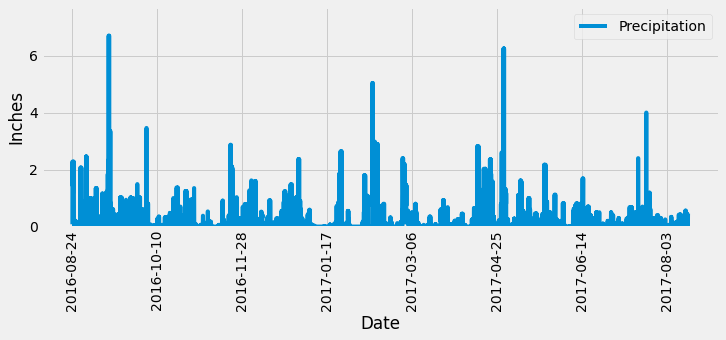

In [327]:
# Use Pandas Plotting with Matplotlib to plot the data
sorted_one_year_data.plot(x='date',y='prcp', figsize=(10,5), rot='vertical', label="Precipitation")

plt.tight_layout()
min_ylim = sorted_one_year_data['prcp'].min()
max_ylim = sorted_one_year_data['prcp'].max()
plt.ylim(min_ylim, max_ylim+1)

plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()

In [332]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_one_year_data.describe()

,prcp
count,18135.000000
mean,0.176462
std,0.460187
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [356]:
# Design a query to show how many stations are available in this dataset?
unique_stations = session.query(station)
unique_stations_grouped = unique_stations.group_by('station')
for u in unique_stations_grouped:
    print(u.station)

USC00511918
USC00513117
USC00514830
USC00516128
USC00517948
USC00518838
USC00519281
USC00519397
USC00519523


In [354]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
prcp_summary_statistics = cleaned_combined_df.groupby(['station']).count()
prcp_summary_statistics.sort_values('id', ascending=False)

,id,date,prcp,tobs,name,latitude,longitude,elevation
station,,,,,,,,
USC00519281,2772,2772,2772,2772,2772,2772,2772,2772
USC00513117,2696,2696,2696,2696,2696,2696,2696,2696
USC00519397,2685,2685,2685,2685,2685,2685,2685,2685
USC00519523,2572,2572,2572,2572,2572,2572,2572,2572
USC00516128,2484,2484,2484,2484,2484,2484,2484,2484
USC00514830,1937,1937,1937,1937,1937,1937,1937,1937
USC00511918,1932,1932,1932,1932,1932,1932,1932,1932
USC00517948,683,683,683,683,683,683,683,683
USC00518838,342,342,342,342,342,342,342,342


In [406]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# Create a query to collect min, max, and avg temp for the most active station USC00519281
# Using label to call on each result
min_max_avg = (session.query(func.min(measurement.tobs).label("min_temp"), func.max(measurement.tobs).label("max_temp"), 
                             func.avg(measurement.tobs).label("avg_temp")).filter(measurement.station == 'USC00519281'))

#  Create a variable the get the .one() first value for each query 
res = min_max_avg.one()

# Create variable for each result 
temp_min = res.min_temp
temp_max = res.max_temp
temp_avg = res.avg_temp

# Print
print(f"The minimum temperature for the busiest station, USC00519281 is {temp_min} degrees")
print(f"The maximum temperature for the busiest station, USC00519281 is {temp_max} degrees")
print(f"The average tempurature for the busiest statio, USC00519281 is {temp_avg} degrees")

The minimum temperature for the busiest station, USC00519281 is 54.0 degrees
The maximum temperature for the busiest station, USC00519281 is 85.0 degrees
The average tempurature for the busiest statio, USC00519281 is 71.66378066378067 degrees


Text(0, 0.5, 'Frequency')

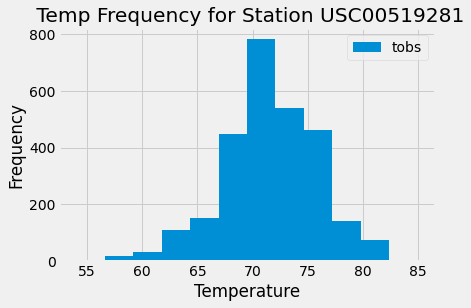

In [444]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Create query where we .filter() on mesaurement.station to == USC00519281 the busiest station
busiest_station_temp = pd.read_sql(sql="SELECT * FROM measurement WHERE station = 'USC00519281'", con=conn)
dropped_busiest_station_temp = busiest_station_temp.dropna()

busiest_station_temp.hist(column='tobs', grid=True, bins=12, legend=True)
plt.title(" Temp Frequency for Station USC00519281")
plt.xlabel("Temperature")
plt.ylabel("Frequency")

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
